<a href="https://colab.research.google.com/github/matiwertyl2/nn_project/blob/master/NNProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q torch torchvision
!pip install -q pillow==4.1.1
!pip install -q gdown

In [2]:
# Common imports

%pylab inline

import torch

import numpy as np

import PIL
from PIL import Image
import os

from matplotlib import patches

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torch.utils.data import Dataset, DataLoader

import httpimport
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
    import common.plotting

Populating the interactive namespace from numpy and matplotlib


In [0]:
CUDA = True

def to_np(x):
    return x.detach().cpu().numpy()

def to_tensor(x, **kwargs):
    x = torch.from_numpy(x)
    if CUDA:
        x = x.cuda()
    return torch.tensor(x, **kwargs)

# Stanford Dogs Dataset

In [0]:
class SubsampledImageDataset(Dataset):
    def __init__(self, dataset, indexes, transform, **kwargs):
        super(SubsampledImageDataset, self).__init__(**kwargs)
        self.dataset = dataset
        self.indexes = indexes
        self.transform = transform
    
    def __getitem__(self, i):
        img, label = self.dataset[self.indexes[i]]
        img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.indexes)

In [0]:
# fetch the data
![ -e images.tar ] || wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
![ -d Images ] || tar xf images.tar

In [0]:
dogs_whole_dataset = torchvision.datasets.ImageFolder('./Images/')
idx_to_label = dogs_whole_dataset.classes

all_indexes = np.random.permutation(len(dogs_whole_dataset))
train_size = int(len(all_indexes) * 0.8)

dogs_train_dataset = SubsampledImageDataset(
    dogs_whole_dataset,
    all_indexes[:train_size],
    torchvision.transforms.Compose([
        torchvision.transforms.Resize(299),
        torchvision.transforms.CenterCrop(299),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
    ]))

def noise(x):
    return x + 0.04*torch.randn_like(x)

dogs_train_aug = SubsampledImageDataset(
    dogs_whole_dataset,
    all_indexes[:train_size],
    torchvision.transforms.Compose([
        torchvision.transforms.RandomAffine(8, (0.08, 0.08), (0.85, 1)),
        torchvision.transforms.RandomResizedCrop(299),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(noise)
    ]))

dogs_test_dataset = SubsampledImageDataset(
    dogs_whole_dataset,
    all_indexes[train_size:],
    torchvision.transforms.Compose([
        torchvision.transforms.Resize(299),
        torchvision.transforms.CenterCrop(299),
        torchvision.transforms.ToTensor()
    ]))


dogs_datasets = {
    'train': dogs_train_dataset,
    'test': dogs_test_dataset,
    'aug': dogs_train_aug
}

In [0]:
batch_size = 64

dogs_loaders = {
    'train': torch.utils.data.DataLoader(
        dogs_datasets['train'], batch_size=batch_size,
        num_workers=4,
        shuffle=True),
    'aug': torch.utils.data.DataLoader(
        dogs_datasets['aug'], batch_size=batch_size,
        num_workers=4,
        shuffle=True),
    'test': torch.utils.data.DataLoader(
        dogs_datasets['test'], batch_size=batch_size,
        num_workers=4,
        shuffle=False)}

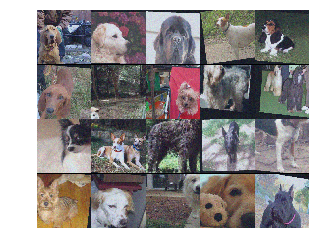

In [0]:
train_batch = next(iter(dogs_loaders['aug']))
common.plotting.plot_mat(to_np(train_batch[0])[:20])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


n02109525-Saint_Bernard


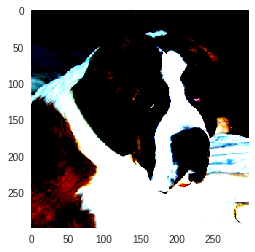

In [0]:
x,y = dogs_train_dataset[5]
print(idx_to_label[y])
plt.imshow(to_np(x.permute(1, 2, 0)))
plt.grid(False)

# Our Dataset

In [365]:
# fetch the data
![ -e data.tar.gz ] || gdown 'https://drive.google.com/uc?export=download&id=1WSWZyDZkmwpUkgCq0rKeDRag7pT7yM1w' -O data.tar.gz
![ -e yolo_metadata.npy ] || gdown 'https://drive.google.com/uc?export=download&id=1hOOxP6jVpIB3bO4i9hZNS13kTXPcMuDb' -O yolo_metadata.npy
![ -d data ] || tar zxf data.tar.gz

Downloading...
From: https://drive.google.com/uc?export=download&id=1hOOxP6jVpIB3bO4i9hZNS13kTXPcMuDb
To: /content/yolo_metadata.npy
184MB [00:01, 179MB/s]


In [0]:
class DogsDetectionDataset(Dataset):
    
    def __init__(self, meta_file, root_dir, imsize=224):
        self.meta = np.load(meta_file).astype(np.float32)
        self.root = root_dir
        self.imsize = imsize
        
    def __len__(self):
        return self.meta.shape[0]
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root, str(idx) + '.jpg')
        image = Image.open(img_name)
        image = image.resize((self.imsize, self.imsize), PIL.Image.ANTIALIAS)
            
        torch_img = to_tensor(numpy.array(image, dtype=np.float32))
        torch_meta = to_tensor(self.meta[idx])
        return (torch_img, torch_meta)

In [0]:
class SubsampledImageDataset(Dataset):
    def __init__(self, dataset, indexes, **kwargs):
        super(SubsampledImageDataset, self).__init__(**kwargs)
        self.dataset = dataset
        self.indexes = indexes
    
    def __getitem__(self, i):
        img, label = self.dataset[self.indexes[i]]
        return img, label
    
    def __len__(self):
        return len(self.indexes)

In [0]:
dogs_dataset = DogsDetectionDataset('./yolo_metadata.npy', './raw')

all_indexes = np.random.permutation(len(dogs_dataset))
train_size = int(len(all_indexes) * 0.8)

dogs_train_dataset = SubsampledImageDataset(
    dogs_dataset[:train_size],
    all_indexes)

dogs_test_dataset = SubsampledImageDataset(
    dogs_dataset,
    all_indexes[train_size:])


dogs_datasets = {
    'train': dogs_train_dataset,
    'test': dogs_test_dataset,
}

In [0]:
batch_size = 64

dogs_loaders = {
    'train': torch.utils.data.DataLoader(
        dogs_datasets['train'], batch_size=batch_size,
        num_workers=0,
        shuffle=True),
    'test': torch.utils.data.DataLoader(
        dogs_datasets['test'], batch_size=batch_size,
        num_workers=0,
        shuffle=False)}

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


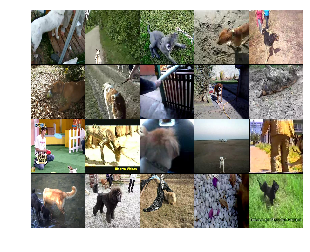

In [344]:
train_batch = next(iter(dogs_loaders['test']))
common.plotting.plot_mat(to_np(train_batch[0].permute(0, 3, 1, 2))[:20])

In [0]:
def batch_label_to_bbox(label):
    grid = label.shape[1]
    stride = 1.0 / float(grid)
    
    label = label.view(label.shape[0], -1, 5)
    conf = label[:, :, 4]

    best = torch.argmax(conf, dim=1)
    pred = []
    for i in range(label.shape[0]):
        b = best[i]
        x, y = int(b % grid), int(b / grid)
        coords = label[i, b, :]
        
        box_x, box_y = stride * (x+coords[0]), stride * (y+coords[1])
        box_w, box_h = coords[2]*coords[2], coords[3]*coords[3]
        
        pred.append(torch.FloatTensor([box_x, box_y, box_w, box_h]))
            
    return torch.stack(pred, dim=0)
                    
def show_image_bbox(img, meta):
    img = to_np(img).astype(int)
    imsize = img.shape[0]
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    ax.grid(False)
    
    if meta.dim() == 3:
        meta = meta.unsqueeze(0)
    
    bsize = meta.shape[0]
    boxes = imsize * batch_label_to_bbox(meta)    
    for i in range(bsize):
        x, y, w, h = boxes[i, :]
        
        # Create a Rectangle patch
        rect = patches.Rectangle((x-w/2, y-h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


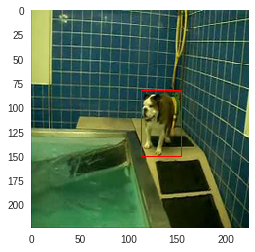

In [346]:
x, y = dogs_dataset[0]
show_image_bbox(x, y)

In [0]:
def batch_change_repr(batch):
    mid_xy = batch[:, :2]
    wh = batch[:, 2:4]
    topleft_xy = mid_xy - wh/2
    bottomright_xy = mid_xy + wh/2
    return torch.cat((topleft_xy, bottomright_xy), 1)

def batch_iou(pred, truth):
    pred = batch_label_to_bbox(pred)
    pred_xy = pred[:, :2]
    pred_wh = pred[:, 2:4]
    
    truth = batch_label_to_bbox(truth)
    truth_xy = truth[:, :2]
    truth_wh = truth[:, 2:4]

    
#     stride = 1.0 / 24.0   
#     x_pred, y_pred = torch.floor(torch.div(pred[:, 0], stride)), torch.floor(torch.div(pred[:, 1], stride))
#     x_truth, y_truth = torch.floor(torch.div(truth[:, 0], stride)), torch.floor(torch.div(truth[:, 1], stride))
    
#     x_score = torch.eq(x_pred, x_truth)
#     y_score = torch.eq(y_pred, y_truth)
    
#     return (x_score * y_score).type(pred.type())
        
    pred_area = torch.prod(pred_wh, dim=1)
    truth_area = torch.prod(truth_wh, dim=1)
    
    pred = torch.cat((pred_xy, pred_wh), dim=1)
    pred = batch_change_repr(pred)
    truth = torch.cat((truth_xy, truth_wh), dim=1)
    truth = batch_change_repr(truth)
    
    both = torch.stack((pred, truth), dim=2)
    
    topleft = torch.max(both[:, :2, :], dim=2)[0]
    bottomright = torch.min(both[:, 2:, :], dim=2)[0]
    
    inter_wh = torch.clamp(bottomright - topleft, min=0.0)
    inter_area = torch.prod(inter_wh, dim=1)
    
    return inter_area / (pred_area + truth_area - inter_area)

# Conv Based YOLO

In [0]:
class Preprocess(nn.Module):
    """Pytorch module that normalizes data for a VGG network
    """
    # These values are taken from http://pytorch.org/docs/master/torchvision/models.html
    RGB_MEANS = torch.FloatTensor([0.485, 0.456, 0.406])[None, :, None, None]
    RGB_STDS = torch.FloatTensor([0.229, 0.224, 0.225])[None, :, None, None]
    
    def forward(self, x):
        """Normalize a single image or a batch of images
        
        Args:
            x: a pytorch Variable containing and float32 RGB image tensor with 
              dimensions (batch_size x width x heigth x RGB_channels) or 
              (width x heigth x RGB_channels).
        Returns:
            a torch Variable containing a normalized BGR image with shape 
              (batch_size x BGR_channels x width x heigth)
        """
        if x.dim() == 3:
            x = torch.unsqueeze(x, 0)
        # x is batch * width * heigth *channels,  
        # make it batch * channels * width * heigth 
        if x.size(3) == 3:
            x = x.permute(0, 3, 1, 2)
        means = self.RGB_MEANS
        stds = self.RGB_STDS
        if x.is_cuda:
            means = means.cuda()
            stds = stds.cuda()
        x = (x - Variable(means)) / Variable(stds)
        return x

In [0]:
# def select_indices(input, indices):
#     # output[i, j, k, l] = input[i, j, k, indices[i, j, k], l]
#     new_shape = (input.shape[0], input.shape[1], input.shape[2], input.shape[4])
#     output = np.fromfunction(lambda i, j, k, l : 
#         input[np.array(i, dtype=int), np.array(j, dtype=int), np.array(k, dtype=int), 
#             indices[np.array(i, dtype=int), np.array(j, dtype=int), np.array(k, dtype=int)],
#             np.array(l, dtype=int)], new_shape)
#     return output

class Yolo(nn.Module):
    
    def __init__(self, module, out_features, grid=24, boxes=2, classes=0, intermediate=16384):
        super(Yolo, self).__init__()
        self.classes = classes
        self.model = model
        self.grid = grid
        self.boxes = boxes
        
        self.preprocess = Preprocess()
        
        for p in self.model.parameters():
            p.requires_grad = False
        
        self.model.fc = nn.Sequential(
            nn.Linear(out_features, intermediate),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(intermediate, grid*grid*(5*boxes+classes)),
            nn.Sigmoid()
        )
        
        self.coord = 3.5
        self.noobj = 0.1
#         self.I = torch.eye(self.classes)
        
#     def int_to_onehot(self, x):
#         shape = x.shape
#         shape += (-1,)
#         return (self.I[x.flatten()]).reshape(shape)
        
    def get_responsible(self, out):
        boxes = out.view(out.size(0), self.grid, self.grid, self.boxes, -1)
        conf = boxes[:, :, :, :, 4]
        
        resp = torch.argmax(conf, dim=3)
        return select_indices(boxes, resp)
    
    def forward(self, x):
        x = self.preprocess(x)
        x = self.model(x)
        x = x.view(x.size(0), self.grid, self.grid, -1)
        return x
        
    def loss(self, out, y, biter):
#         boxes = out[:, :, :, :5*self.boxes]

        resp = self.get_responsible(out)
        y_conf = y[:, :, :, 4]
        
        E = resp - y
        E_coords = E[:, :, :, :4]
        E_conf   = E[:, :, :, 4]
        
        L_coords = self.coord * torch.sum(y_conf.unsqueeze(3) * E_coords * E_coords)
        L_conf = torch.sum((y_conf + (1-y_conf)*self.noobj) * E_conf * E_conf)
                
#         classes = out[:, :, :, 5*self.boxes:]
#         y_class = y[:, :, :, 5].squeeze()
#         y_onehot = self.int_to_onehot(y_class)
        
#         L += y_conf * torch.pow(classes-y_onehot, 2)
                    
        return L_coords + L_conf
    
    def predict(self, out):
        return self.get_responsible(out)

# Training YOLO

In [0]:
# Training code is based on assignment 4
def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    iou_sum = 0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()
        with torch.no_grad():
            out = model.forward(x)
            pred = model.predict(out)
            iou_sum += torch.sum(batch_iou(y, pred))
            num_examples += x.size(0)
    return 100.0 * (1.0 - iou_sum / num_examples)

        
def train(model, data_loaders, optimizer, num_epochs=1,
          log_every=100, cuda=True):
    if cuda:
        model.cuda()
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': [], 'train_loss2': []}
    print('Training the model!')
    print('You can interrupt it at any time.')
    try:
        while epoch < num_epochs:
            model.train()
            # model.train_mode()
            epoch += 1
            biter = 0
            for x, y in data_loaders['train']:
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1
                biter += 1
                
                optimizer.zero_grad()
                out = model.forward(x)
                loss = model.loss(out, y, biter)
                loss.backward()
                optimizer.step()
                
                pred = model.predict(out)
                iou = torch.sum(batch_iou(y, pred))
                err_rate = 100 * (1.0 - iou / out.size(0))

                history['train_losses'].append(loss.item())
                history['train_errs'].append(err_rate.item())
                
                if iter_ % log_every == 0:
                    print "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%" \
                          .format(iter_, loss.item(), err_rate.item())

            val_err_rate = compute_error_rate(model, data_loaders['test'], cuda)
            history['val_errs'].append((iter_, val_err_rate.item()))

            if val_err_rate < best_val_err:
                best_epoch = epoch
                best_val_err = val_err_rate
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                .format(epoch, val_err_rate, num_epochs)
            print '{0}\n{1}\n{0}'.format('-' * len(m), m)
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print "\nLoading best params on validation set (epoch %d)\n" %(best_epoch)
        model.parameters = best_params
    plot_history(history)

def plot_history(history):
    figsize(16, 4)
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    legend()
        
    subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    ylim(0,20)
    legend()        

Training the model!
You can interrupt it at any time.


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Minibatch     10  | loss 699.61 | err rate 92.85%
Minibatch     20  | loss 294.51 | err rate 91.12%
----------------------------------------------------------
After epoch  1 | valid err rate: 74.67% | doing 500 epochs
----------------------------------------------------------
Minibatch     30  | loss 139.18 | err rate 82.00%
Minibatch     40  | loss 118.99 | err rate 73.04%
Minibatch     50  | loss 117.26 | err rate 69.05%
----------------------------------------------------------
After epoch  2 | valid err rate: 71.07% | doing 500 epochs
----------------------------------------------------------
Minibatch     60  | loss 122.72 | err rate 69.38%
Minibatch     70  | loss 105.44 | err rate 66.04%
----------------------------------------------------------
After epoch  3 | valid err rate: 71.17% | doing 500 epochs
----------------------------------------------------------
Minibatch     80  | loss 106.25 | err rate 69.37%
Minibatch     90  | loss 107.61 | err rate 71.02%
Minibatch    100  |

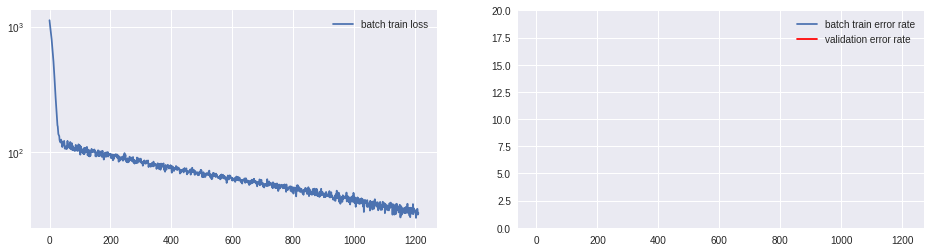

In [362]:
resnet = torchvision.models.resnet50(pretrained=True)
out_features = resnet.fc.in_features
yolo = Yolo(resnet, out_features)

# Train only the params of the classifier
optimizer = torch.optim.Adam(yolo.model.fc.parameters(), lr=0.00002)

train(yolo, dogs_loaders, optimizer,
      num_epochs=500, log_every=10, cuda=True)

In [323]:
x, y = dogs_dataset[all_indexes[25]]
y = y.view(-1, 5)
y_conf = y[:, 4]
best = torch.argmax(y_conf, dim=0)
best_x, best_y = int(best / 24), int(best % 24)
print best_x, best_y

y = y.view(24, 24, -1).unsqueeze(0)

with torch.no_grad():
    out = yolo.forward(x)
    z = yolo.predict(out)
    
print z[:, best_x, best_y, :]
print y[:, best_x, best_y, :]

# z = torch.rand(1, 24, 24, 5).cuda()
# w = z.clone()

# z[:, best_x, best_y, :4] = torch.zeros(4).cuda()

# w[:, best_x, best_y, 4] = 0.995
print batch_iou(y, z)

w = z

w = w.squeeze().view(-1, 5)
w_conf = w[:, 4]
best = torch.argmax(w_conf, dim=0)
best_x, best_y = int(best / 24), int(best % 24)
print best_x, best_y
print w[best, :]

# y = torch.cat((y, y), dim=3)
# z = torch.cat((z, z), dim=3)
# w = torch.cat((w, w), dim=3)

# print yolo.loss(w, y)[0]
# print yolo.loss(z, y)[0]

9 8
tensor([[0.8356, 0.6882, 0.7107, 0.7281, 0.5275]], device='cuda:0')
tensor([[0.8320, 0.7000, 0.7127, 0.7246, 1.0000]], device='cuda:0')
tensor([0.9849])
9 8
tensor([0.8356, 0.6882, 0.7107, 0.7281, 0.5275], device='cuda:0')


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


tensor([[0.4190, 0.4167, 0.6620, 0.7033]])


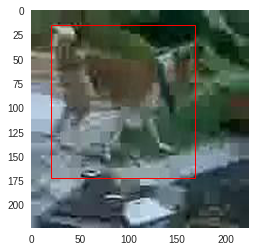

tensor([[0.5239, 0.5632, 0.5100, 0.5887]])


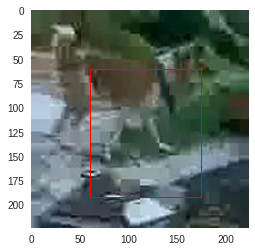

In [359]:
x, y = dogs_dataset[371]
y = y.unsqueeze(0)

bbox = batch_label_to_bbox(y)
print bbox

show_image_bbox(x, y)

x.cuda()
y.cuda()
yolo.cuda()
out = yolo.forward(x)
pred = yolo.predict(out)

bbox = batch_label_to_bbox(pred)
print bbox

show_image_bbox(x, pred)